# Introduction

**SET09122 Artificial Intelligence Coursework**

Created by: Valeri Vladimirov 40399682

This is the programming part of the coursework and will use the IMDB dataset provided by keras and do the following:


1.   Create two functions that return the unigrams and bigrams.
2.   Apply text preprocessing techniques.
3.   Print the 20 most used unigrams and bigrams.
4.   Implement Bag Of Words.
5.   Create a Decision Tree.
6.   Evaluate the Decision Tree using the appropriate metrics.

Additional information, justification and conclusions can be found in the report.



## 1. Unigrams and Bigrams

Import/download the necessary libraries, dataset, packages and collections, which will be used throughout the coursework.

In [ ]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from collections import Counter
from nltk.util import ngrams
from keras.datasets import imdb
(training_data, training_targets), (testing_data, testing_targets) = imdb.load_data()
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn.tree import DecisionTreeClassifier 
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report, confusion_matrix
import pydotplus
import seaborn as sns
import string
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('wordnet')

The following code will get the first **2500** reviews, transform them and add them to one string (sentence) and an array which will be later used for the BOW. 

### **Note**: Only 2500 sentences will be used because it takes a lot of time to process all of the sentences in the dataset. Also because using the whole dataset makes the processing slower and could lead to **IOPub data rate exceeded. The notebook server will temporarily stop sending output to the client in order to avoid crashing it.**



In [ ]:
index = imdb.get_word_index()
reverseIndex = dict([(value, key) for (key, value) in index.items()])
decodedReviews = ''
arrayReviews = []
for i in range(2500):
  decodedReviews = decodedReviews + " ".join( [reverseIndex.get(i - 3, "#") for i in training_data[i]] )
  decodedReviews = decodedReviews + "\n"
  arrayReviews.append(" ".join([reverseIndex.get(i - 3, "#") for i in training_data[i]]))

The following piece of code will do the following **preprocessing techniques**:


1.   Remove the break lines "br br". It was found that in the dataset there are reviews which contain break lines. When transforming the dataset the punctuations like </> were removed, which left only the "br br".
2.   Turn all the words to lower case. (Example: "Movie" to "movie")
3.   Remove all other kinds of punctuations, such as "#" and etc.
4.   Removing all of the stop words. (Example: "the", "as")
5.   Lemmatizing the words (Example: turning "movies" to "movie")

And then add the preprocessed reviews to a new array, which will be used for creation of unigrams and bigrams. These preprocessing techniques were used because they will produce better and cleaner results for the unigrams and bigrams and also for the decision tree, having higher accuracy and other metrics. (Additionaly there are other techniques which could have been performed, such as removing the numbers, however it was decided that these are not needed and won't improve the performance a lot). 


In [3]:
preprocessed = decodedReviews.replace("br br", "")
preprocessed = preprocessed.lower()
preprocessed = preprocessed.translate(str.maketrans('', '', string.punctuation))
lemmatizer=WordNetLemmatizer()
preprocessedString=""

for item in arrayReviews:
  item = item.replace("br br", "")
  item = item.lower()
  item = item.translate(str.maketrans('', '', string.punctuation))
  for word in item.split():
    if word not in stopwords.words('english'):
      preprocessedString = preprocessedString + lemmatizer.lemmatize(word) + " "

This is the function to return unigrams.

In [4]:
def extract_unigram(reviews): 
  return word_tokenize(reviews)

The following code will print all of the unigrams.

In [ ]:
extract_unigram(preprocessedString)

This is the function to return bigrams.


In [6]:
def extract_bigram(reviews):
  bigrams = nltk.bigrams(nltk.word_tokenize(reviews))
  print(*map(' '.join, bigrams), sep='\n')

The following code will print all of the bigrams.

In [ ]:
extract_bigram(preprocessedString)

The following piece of code will print the 20 most used unigrams and the number of their occurance.


In [ ]:
for word in Counter(extract_unigram(preprocessedString)).most_common(20):
  print(word)

The following piece of code will print the 20 most used bigrams and the number of their occurance. However it will use the nltk bigrams function rather than the function created above.

In [ ]:
bigrm = nltk.bigrams(preprocessedString.split())
for word in Counter(bigrm).most_common(20):
  print(word)

## 2. Text Representation


The following code will go over the same process as the preprocessing techniques above, however it will add the preprocessed reviews to an array. Because an array has to be used for the BOW.


In [11]:
lemmatizer=WordNetLemmatizer()
reviewsBow=[]
for rev in arrayReviews:
  review=""
  rev = rev.replace("br br", "")
  rev = rev.lower()
  rev = rev.translate(str.maketrans('', '', string.punctuation))
  for word in rev.split():
    if word not in stopwords.words('english'):
      review = review + lemmatizer.lemmatize(word) + " "
  reviewsBow.append(review)

The Bag of Words will be created using sklearn and for that a CountVectorizer will be used to tokenize the text and count the occurances of each word.

In [12]:
vectorizer = CountVectorizer()
sentences_as_bag_of_words = vectorizer.fit_transform(reviewsBow)

The following code can be used to see how each word is shown when using **BOW**.
This example is for the first review. Words are shown as "(0, 8719)	6", where 8719 representes the word **"film"** and 6 represents the number of occurances in the review.

In [ ]:
for word in sentences_as_bag_of_words[0]: 
  print(word)

To turn the words into **BOW** they have to be turned into arrays.

In [ ]:
bow_vectors = sentences_as_bag_of_words.toarray()
bow_vectors

## 3. Decision Tree

In order to create a decision tree, first the BOW will have to be turned into a **DataFrame**.

In [15]:
df = pd.DataFrame(bow_vectors)

The dataset will be split into training (80%) and test (20%), which will be used later in the evaluation metrics.

In [16]:
train_features = df.iloc[:2000,:-1]
test_features = df.iloc[2000:,:-1]

The following code will also split the labels for the first 2500 sentences into training (80%) and test (20%), which will also be used for the evaluation metrics.

In [17]:
train_labels=[]
for i in range(2000):
  train_labels.append(training_targets[i])

test_labels=[]
for i in range(2000, 2500):
  test_labels.append(training_targets[i])

The following code creates the decision tree by using **entropy** as the criterion and the training datasets for the fit.


In [18]:
tree = DecisionTreeClassifier(criterion = 'entropy').fit(train_features, train_labels)

The following code will visualise the decision tree.

In [19]:
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## 4. Evaluation Metrics


Predictions to the test dataset have to be made.

*Bearing in mind that the tree created could be a bit different from the previous one and from the one explained in the report. Also evaluation metrics such as accuracy and etc. could be different from those in the report. Although the results are almost the same.*

In [20]:
predicted = tree.predict(test_features)

The **confusion matrix** of the decision tree shows the true negative, false positive, false negative and true positive values. They can be seen by doing the following:

In [21]:
true_negative, false_positive, false_negative, true_positive = confusion_matrix(test_labels, predicted).ravel()
print("True Negatives: ",true_negative)
print("False Positives: ",false_positive)
print("False Negatives: ",false_negative)
print("True Positives: ",true_positive)

True Negatives:  157
False Positives:  84
False Negatives:  76
True Positives:  183


And can be visualised as follows:

(array([0.5, 1.5]), <a list of 2 Text major ticklabel objects>)

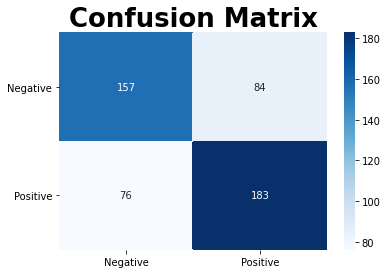

In [22]:
%matplotlib inline
from matplotlib import pyplot as plt
sns.heatmap(confusion_matrix(test_labels, predicted), annot=True, fmt='g', cmap='Blues', xticklabels=("Negative", "Positive"), yticklabels=("Negative", "Positive"))
plt.title("Confusion Matrix", fontsize=26, fontweight="bold")
plt.yticks(rotation=0)

To calculate the **accuracy**:

In [23]:
accuracy = (true_negative+true_positive)*100/(true_positive+true_negative+false_positive+false_negative) 
print("Accuracy = {:0.2f}%".format(accuracy))

Accuracy = 68.00%


To calculate the **precision**:

In [24]:
precision = true_positive/(true_positive+false_positive) 
print("Precision = {:0.2f}".format(precision))

Precision = 0.69


To calculate the **recall**:

In [25]:
recall = true_positive/(true_positive+false_negative) 
print("Recall = {:0.2f}".format(recall))

Recall = 0.71


To calculate the **F1 score**:

In [26]:
f1_score = (2*precision*recall)/(precision + recall)
print("F1 Score = {:0.2f}".format(f1_score))

F1 Score = 0.70


To calculate the **specificity**:

In [27]:
specificity = true_negative/(true_negative+false_positive)
print("Specificity = {:0.2f}".format(specificity))

Specificity = 0.65


The above metrics can also be seen by creating a **classification report** as follows:

In [28]:
print(classification_report(test_labels, predicted))

              precision    recall  f1-score   support

           0       0.67      0.65      0.66       241
           1       0.69      0.71      0.70       259

    accuracy                           0.68       500
   macro avg       0.68      0.68      0.68       500
weighted avg       0.68      0.68      0.68       500

